In [ ]:
# Here, we'll install and use a pre-release of AI2-THOR.
!pip install --extra-index-url https://ai2thor-pypi.allenai.org ai2thor==0+391b3fae4d4cc026f1522e5acf60953560235971 &> /dev/null
!pip install ai2thor-colab prior --upgrade &> /dev/null
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import prior

dataset = prior.load_dataset("procthor-10k")

Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 2586.77it/s]


In [ ]:
from ai2thor.controller import Controller
import ai2thor_colab
from ai2thor_colab import plot_frames

In [ ]:
ai2thor_colab.start_xserver()

In [ ]:
object_list = ['Book', 'Pillow', 'SprayBottle', 'Mug', 'Apple', 'Pen', 'Bowl', 'RemoteControl', 'AlarmClock', 'Laptop']

In [ ]:
house_id_list = [497, 492, 510, 551, 565, 711, 8480, 1486, 7558, 1577, 1782, 1967, 2452, 2741, 2806, 3456, 3730, 3755]

In [ ]:
train_set = dataset['train']
object_removal_map = {}
selected_house_objects = {house_id: {obj_type:{} for obj_type in object_list} for house_id in house_id_list}

for house_id in house_id_list:
  object_removal_map[house_id] = []
  house_obj_candidates = {obj_type: [] for obj_type in object_list}
  house = train_set[house_id]
  objs = house['objects']
  for asset in objs:
    obj_type = asset['id'].split('|')[0]
    if obj_type in object_list:
      house_obj_candidates[obj_type].append({'position': asset['position'], 'objectId': asset['id'], 'parentObj':""})
    if 'children' in asset.keys():
      for child_asset in asset['children']:
        obj_type = child_asset['id'].split('|')[0]
        if obj_type in object_list:
          house_obj_candidates[obj_type].append({'position':child_asset['position'], 'objectId': child_asset['id'], 'parentObj':asset['id'].split('|')[0]})
  for object_type in object_list:
    selected_house_objects[house_id][object_type] = house_obj_candidates[object_type][0] 
    if len(house_obj_candidates[object_type]) > 1:
      for remove_object in range(1,len(house_obj_candidates[object_type])):
        object_removal_map[house_id].append(house_obj_candidates[object_type][remove_object]['objectId'])

In [ ]:
selected_house_objects[497]['Book']

{'position': {'x': 2.4311771392822266,
  'y': 0.7677839994430542,
  'z': 9.685639381408691},
 'objectId': 'Book|surface|3|34',
 'parentObj': 'DiningTable'}

In [ ]:
dataset['train'][492]['doors'][0]

{'assetId': 'Doorframe_Double_5',
 'assetOffset': {'x': -0.0031945938244462013,
  'y': -0.0,
  'z': 0.0559871569275856},
 'boundingBox': {'max': {'x': 4.742458527934937,
   'y': 2.0956013202667236,
   'z': 0},
  'min': {'x': 2.8021223005179445, 'y': 0, 'z': 0}},
 'id': 'door|2|3',
 'room0': 'room|3',
 'room1': 'room|2',
 'wall0': 'wall|3|4.92|0.00|4.92|8.20',
 'wall1': 'wall|2|4.92|0.00|4.92|8.20'}

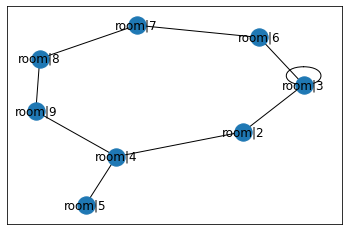

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

class GraphVisualization:
   
    def __init__(self):
          
        # visual is a list which stores all 
        # the set of edges that constitutes a
        # graph
        self.visual = []
          
    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)
          
    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()
  
# Driver code
G = GraphVisualization()

for door in dataset['train'][492]['doors']:
  G.addEdge(door['room0'], door['room1'])

G.visualize()

In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy as np
import math

# Right == +90
# Left == -90

Heading = [90, 180, 270, 0]

def inRoom(room, object_pos):
  
  id = ""
  ty = ""
  point = Point(object_pos['x'],object_pos['z'])

  for r in room:
    p_list = []
    for points in r['floorPolygon']:
      p_list.append((points['x'], points['z']))
    polygon = Polygon(p_list)
    if polygon.contains(point):
      ty = r['roomType']
      id = r['id']
      return ty, id
  return "", ""

def get_heading(point1, point2, intial_heading):
    point1 = Point(point1['x'],point1['z'])
    point2 = Point(point2['x'],point2['z'])
    angle = math.degrees(math.atan2(point2.y-point1.y, point2.x-point1.x))

    if angle < 0:
      angle = 360 + angle
    
    difference = angle - Heading[intial_heading]
    
    while difference < -180:
       difference += 360
    while (difference > 180):
       difference -= 360;
    if difference > 0 and difference <= 90:
      return "Left"
    elif difference > 90 and difference <= 180:
      return "BackwardLeft"  
    elif difference < 0 and difference >= -90:
      return "Right"
    elif difference < -90 and difference >= -180:
      return "BackwardRight"  
    return difference

In [ ]:
%cd drive/MyDrive/semantic_mapping_project/

/content/drive/MyDrive/semantic_mapping_project


In [ ]:
!mkdir ./yash_expert_annotations/forTraining

In [ ]:
import json
import os
from tqdm import tqdm

houses = house_id_list

for house_id in houses:
  controller_x = Controller(
      scene=dataset['train'][house_id],
      visibilityDistance=2.0,
      gridSize = 0.50
    )
  for obj in tqdm(object_list):
    try:
      with open('./yash_expert_annotations/house_'+str(house_id)+'_'+obj+".json", "r") as f:
        data = json.load(f)
    except:
      continue
    house = dataset['train'][data['house_id']]
    intial_heading = int(house['metadata']['agent']['rotation']['y'] / 90)
    curr_heading = intial_heading
    controller = controller_x
    obj_ = selected_house_objects[house_id][data['target_object_type']]
    for ac_id in tqdm(range(len(data['actions']))):
      ac = data['actions'][ac_id]['action']
      if ac == 'RotateRight':
        curr_heading = (curr_heading+3) % 4
      if ac == 'RotateLeft':
        curr_heading = (curr_heading+1) % 4
      if ac not in ['PickUpObject','OpenObject', 'end']: 
        controller.step(action=ac)
      data['actions'][ac_id]['agent_position'] = controller.last_event.metadata['agent']['position']
      data['actions'][ac_id]['obj_direction'] = get_heading(data['actions'][ac_id]['agent_position'], obj_['position'], curr_heading)
      data['actions'][ac_id]['roomType'], data['actions'][ac_id]['roomId'] = inRoom(house['rooms'], data['actions'][ac_id]['agent_position'])
    
    try:
      with open('./yash_expert_annotations/forTraining/house_'+str(house_id)+'_'+obj+".json", "w") as f:
        json.dump(data,f)
    except:
      continue

100%|██████████| 10/10 [04:21<00:00, 26.16s/it]


In [ ]:
for ac_id in tqdm(range(len(data['actions']))):
      ac = data['actions'][ac_id]['action']
      if ac == 'RotateRight':
        curr_heading = (curr_heading+3) % 4
      if ac == 'RotateLeft':
        curr_heading = (curr_heading+1) % 4
      if ac not in ['PickUpObject','OpenObject', 'end']: 

In [ ]:
house_id_list = [497, 492, 510, 551, 565, 711, 8480, 1486, 7558, 1577, 1782, 1967, 2452, 2741, 2806, 3456, 3730, 3755]

In [ ]:
len(house_id_list)

18

In [ ]:
dataset['train'][492]['objects'][0]

{'assetId': 'Countertop_I_8x2',
 'children': [{'assetId': 'Lettuce_20',
   'id': 'Lettuce|surface|2|2',
   'kinematic': False,
   'position': {'x': 8.59990119934082,
    'y': 1.0170215368270874,
    'z': 0.3333914279937744},
   'rotation': {'x': -0.0, 'y': 0.0, 'z': 0.0},
   'layer': 'Procedural2'},
  {'assetId': 'Houseplant_23',
   'id': 'HousePlant|surface|2|3',
   'kinematic': False,
   'position': {'x': 9.171430587768555,
    'y': 1.2714184522628784,
    'z': 0.36119943857192993},
   'rotation': {'x': -0.0, 'y': 0.0, 'z': 0.0},
   'layer': 'Procedural2'},
  {'assetId': 'Spatula_1',
   'id': 'Spatula|surface|2|11',
   'kinematic': False,
   'position': {'x': 9.281537055969238,
    'y': 0.9511368274688721,
    'z': 0.17992812395095825},
   'rotation': {'x': -0.0, 'y': 90.0, 'z': -0.0},
   'layer': 'Procedural2'},
  {'assetId': 'Spatula_1',
   'id': 'Spatula|surface|2|12',
   'kinematic': False,
   'position': {'x': 9.514602661132812,
    'y': 0.9497349262237549,
    'z': 0.3286442458

In [ ]:
from ai2thor.server import List
from collections import defaultdict
r = defaultdict()

for house_id in house_id_list:
  house = dataset['train'][house_id]
  objs = selected_house_objects[house_id]
  
  for obj in objs.values():  
    print(obj['objectId'],inRoom(house['rooms'], obj['position']))

In [ ]:
import glob
import json
for folder_name in glob.glob("./"+"**_expert_annotations",recursive=True):
  for file_name in glob.glob(folder_name+"/"+"forTraining/house_**_**.json",recursive=True):
    with open(file_name, 'r') as f:
      data = json.load(f)
    house = dataset['train'][data['house_id']]
    p = house['metadata']['agent']['position']
    r = house['metadata']['agent']['rotation']
    intial_heading = int(r['y'] / 90)
    curr_heading = intial_heading
    for ac_id, ac in enumerate(data['actions']):
      ac = data['actions'][ac_id]['action']
      if ac == 'RotateRight':
        curr_heading = (curr_heading+3) % 4
      if ac == 'RotateLeft':
        curr_heading = (curr_heading+1) % 4
      if ac not in ['PickUpObject','OpenObject', 'end']: 
        if curr_heading == 1:
          if 'MoveAhead':
            p['z'] += 0.5 
          if 'MoveBack':
            p['z'] -= 0.5
          if 'MoveRight':
            p['x'] += 0.5
          if 'MoveLeft':
            p['x'] -= 0.5
        if curr_heading == 2:
          if 'MoveAhead':
            p['x'] -= 0.5 
          if 'MoveBack':
            p['x'] += 0.5
          if 'MoveRight':
            p['z'] += 0.5
          if 'MoveLeft':
            p['z'] -= 0.5
        if curr_heading == 3:
          if 'MoveAhead':
            p['z'] -= 0.5 
          if 'MoveBack':
            p['z'] += 0.5
          if 'MoveRight':
            p['x'] -= 0.5
          if 'MoveLeft':
            p['x'] += 0.5
        if curr_heading == 0:
          if 'MoveAhead':
            p['x'] += 0.5 
          if 'MoveBack':
            p['x'] -= 0.5
          if 'MoveRight':
            p['z'] -= 0.5
          if 'MoveLeft':
            p['z'] += 0.5
      ty, id = inRoom(house['rooms'], p)
      data['actions'][ac_id]['roomType'] = ty
      data['actions'][ac_id]['roomId'] = id
      data['actions'][ac_id]['agent_position'] = p 
      with open(file_name, 'w+') as f:
         json.dump(data,f)

In [ ]:
data.keys()

dict_keys(['house_id', 'intentions', 'target_object_type', 'frames_dir', 'actions', 'pickupable_objects', 'openable_objects'])